# **Graph Classification with DeepSNAP**

This is a tutorial for DeepSNAP graph classification.

In this tutorial, we will at first introduce the basics of DeepSNAP graph classification such as the inductive split.

Then we will perform graph classification by using DeepSNAP on the `TUDataset`.

You might need to **sequentially run all the cells in each section**.

# Installation

Before running the cells, please go to the `Runtime` and `Change runtime type` to `GPU`.

In [1]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install -q deepsnap

1.11.0+cu113
     |████████████████████████████████| 7.9 MB 5.5 MB/s 
     |████████████████████████████████| 3.5 MB 5.0 MB/s 
     |████████████████████████████████| 68 kB 2.9 MB/s 


# Setup

In [2]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.transforms as T
import torch.optim as optim
import matplotlib.pyplot as plt
import networkx as nx
import torch_geometric.nn as pyg_nn

from copy import deepcopy
from torch_geometric.nn import GINConv
from torch.utils.data import DataLoader
from torch_geometric.datasets import TUDataset
from sklearn.metrics import *
from torch.nn import Sequential, Linear, ReLU
from deepsnap.dataset import GraphDataset
from deepsnap.batch import Batch

# DeepSNAP Graph Classification Basics

Different from traditional node classification and link prediction, graph classification usually is an inductive learning task. Therefore, in DeepSNAP we need to specify `task=graph` when we create the `GraphDataset` object and set `transductive=False` when we split the dataset.

## Inductive Graph Classification

We will use the [TUdataset ENZYMES](https://chrsmrrs.github.io/datasets/) as an example.


In [3]:
name = "ENZYMES"
pyg_dataset = TUDataset('./tmp/enzymes', name)
graphs = GraphDataset.pyg_to_graphs(pyg_dataset)

# Specify the task to be graph
dataset = GraphDataset(graphs, task="graph", minimum_node_per_graph=0)

# Set transductive=False (inductive)
dataset_train, dataset_val, dataset_test = \
    dataset.split(transductive=False, split_ratio = [0.8, 0.1, 0.1])
print("{} dataset has {} classes".format(name, dataset.num_graph_labels))
print("{} dataset has {} node features".format(name, dataset.num_node_features))

Extracting tmp/enzymes/ENZYMES/ENZYMES.zip
Processing...
Done!


ENZYMES dataset has 6 classes
ENZYMES dataset has 3 node features


Let's visualize 9 randomly chosen graphs from the `ENZYMES` dataset!

Here graphs with different `graph_label` are visualized using different node colors.

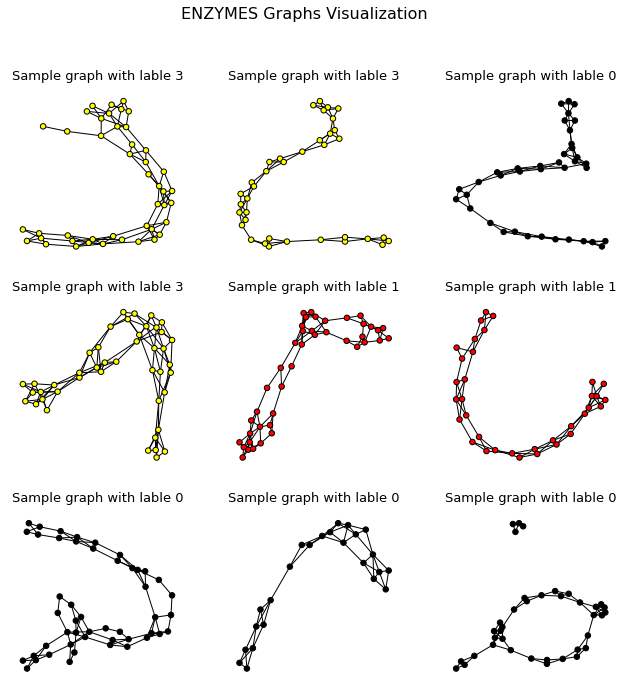

In [4]:
def visualize(dataset):
    color_mapping = {
        0 : 'black',
        1 : 'red',
        2 : 'green',
        3 : 'yellow',
        4 : 'blue',
        5 : 'purple',
    }
    num_graphs_i = 3
    num_graphs_j = 3
    fig, ax = plt.subplots(num_graphs_i, num_graphs_j, figsize=(11, 11))
    fig.suptitle("ENZYMES Graphs Visualization", fontsize=16)
    indices = np.random.choice(np.arange(0, len(dataset)), size=9, replace=False)
    indices = indices.reshape(3, 3)
    for i in range(num_graphs_i):
        for j in range(num_graphs_j):
            index = int(indices[i, j])
            G = dataset[index].G
            label = dataset[index].graph_label.item()
            pos = nx.spring_layout(G, seed=1)
            colors = [color_mapping[label]] * dataset[index].num_nodes
            nodes = nx.draw_networkx_nodes(G, pos=pos, cmap=plt.get_cmap('coolwarm'), \
                node_size=30, ax=ax[(i, j)], node_color=colors)
            nodes.set_edgecolor('black')
            nx.draw_networkx_edges(G, pos=pos, ax=ax[(i, j)])
            ax[(i, j)].set_title("Sample graph with lable {}".format(label), fontsize=13)
            ax[(i, j)].set_axis_off()
    plt.show()
visualize(dataset)

# Graph Classification on TUDataset

Let's start the inductive graph classification on the `ENZYMES` dataset by using the DeepSNAP!

## A Simple GNN Model

In [5]:
class GIN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, args):
        super(GIN, self).__init__()
        self.num_layers = args["num_layers"]

        self.pre_mp = nn.Linear(input_size, hidden_size)
        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()
        for l in range(self.num_layers):
            layer = Sequential(
                Linear(hidden_size, hidden_size), 
                nn.LeakyReLU(), 
                Linear(hidden_size, hidden_size)
            )
            self.convs.append(GINConv(layer))
            self.bns.append(nn.BatchNorm1d(hidden_size))
        self.post_mp = Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(), 
            nn.Linear(hidden_size, output_size),
        )

    def forward(self, data):
        x, edge_index, batch = data.node_feature, data.edge_index, data.batch
        x = self.pre_mp(x)
        for i in range(len(self.convs) - 1):
            x = self.convs[i](x, edge_index)
            x = self.bns[i](x)
        x = self.convs[-1](x, edge_index)
        x = pyg_nn.global_add_pool(x, batch)
        x = self.post_mp(x)
        x = F.log_softmax(x, dim=1)
        return x

    def loss(self, pred, label):
        return F.nll_loss(pred, label)

## Train and Test

In [6]:
def train(train_loader, val_loader, test_loader, args, num_node_features, num_classes, device="cpu"):
    model = GIN(num_node_features, args["hidden_size"], num_classes, args).to(device)
    optimizer = optim.Adam(model.parameters(), lr=args['lr'], weight_decay=5e-4)
    best_model = None
    max_val = -1
    for epoch in range(args["epochs"]):
        total_loss = 0
        model.train()
        num_graphs = 0
        for batch in train_loader:
            batch.to(device)
            optimizer.zero_grad()
            pred = model(batch)
            label = batch.graph_label
            loss = model.loss(pred, label)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * batch.num_graphs
            num_graphs += batch.num_graphs
        total_loss /= num_graphs
        train_acc = test(train_loader, model, device)
        val_acc = test(val_loader, model, device)
        if val_acc > max_val:
            max_val = val_acc
            best_model = deepcopy(model)
        test_acc = test(test_loader, model, device)
        log = "Epoch {}: Train: {:.4f}, Validation: {:.4f}. Test: {:.4f}, Loss: {:.4f}"
        print(log.format(epoch + 1, train_acc, val_acc, test_acc, total_loss))
    return best_model

def test(loader, model, device='cuda'):
    model.eval()
    correct = 0
    num_graphs = 0
    for batch in loader:
        batch.to(device)
        with torch.no_grad():
            pred = model(batch).max(dim=1)[1]
            label = batch.graph_label
        correct += pred.eq(label).sum().item()
        num_graphs += batch.num_graphs
    return correct / num_graphs

## Start Training!

Let's start training!

In [7]:
args = {
    "device" : 'cuda' if torch.cuda.is_available() else 'cpu',
    "hidden_size" : 256,
    "epochs" : 100,
    "lr" : 0.001,
    "num_layers": 3,
    "dataset" : "ENZYMES",
    "batch_size": 32,
}

pyg_dataset = TUDataset('./tmp/enzymes', args["dataset"])
graphs = GraphDataset.pyg_to_graphs(pyg_dataset)
dataset = GraphDataset(graphs, task="graph", minimum_node_per_graph=0)
dataset_train, dataset_val, dataset_test = \
    dataset.split(transductive=False, split_ratio = [0.8, 0.1, 0.1])
num_node_features = dataset.num_node_features
num_classes = dataset.num_graph_labels

train_loader = DataLoader(dataset_train, collate_fn=Batch.collate(),\
    batch_size=args["batch_size"], shuffle=True)
val_loader = DataLoader(dataset_val, collate_fn=Batch.collate(),\
    batch_size=args["batch_size"])
test_loader = DataLoader(dataset_test, collate_fn=Batch.collate(),\
    batch_size=args["batch_size"])

best_model = train(train_loader, val_loader, test_loader, args, num_node_features, num_classes, args["device"])
train_acc = test(train_loader, best_model, args["device"])
val_acc = test(val_loader, best_model, args["device"])
test_acc = test(test_loader, best_model, args["device"])
log = "Best model: Train: {:.4f}, Validation: {:.4f}. Test: {:.4f}"
print(log.format(train_acc, val_acc, test_acc))

Epoch 1: Train: 0.2000, Validation: 0.2333. Test: 0.1667, Loss: 7.1634
Epoch 2: Train: 0.2146, Validation: 0.2667. Test: 0.2333, Loss: 3.7352
Epoch 3: Train: 0.2750, Validation: 0.2667. Test: 0.2167, Loss: 2.2511
Epoch 4: Train: 0.2979, Validation: 0.1833. Test: 0.3000, Loss: 2.0526
Epoch 5: Train: 0.3479, Validation: 0.2833. Test: 0.2667, Loss: 1.9507
Epoch 6: Train: 0.3875, Validation: 0.3000. Test: 0.3333, Loss: 1.6688
Epoch 7: Train: 0.3833, Validation: 0.3333. Test: 0.3833, Loss: 1.6612
Epoch 8: Train: 0.4208, Validation: 0.4000. Test: 0.4000, Loss: 1.6398
Epoch 9: Train: 0.3521, Validation: 0.2833. Test: 0.3167, Loss: 1.5761
Epoch 10: Train: 0.4479, Validation: 0.3833. Test: 0.3833, Loss: 1.5617
Epoch 11: Train: 0.3750, Validation: 0.2667. Test: 0.2833, Loss: 1.5958
Epoch 12: Train: 0.4188, Validation: 0.1667. Test: 0.3000, Loss: 1.6181
Epoch 13: Train: 0.4313, Validation: 0.2833. Test: 0.4167, Loss: 1.5498
Epoch 14: Train: 0.3792, Validation: 0.3333. Test: 0.4000, Loss: 1.5290
E

More examples please see the [examples/graph_classification](https://github.com/snap-stanford/deepsnap/tree/master/examples/graph_classification) folder.

[Next: Mini-batch Sampling with DeepSNAP](https://colab.research.google.com/drive/1rOr-vzrWtnVLhF2CYLbou2acOfjuw_fu?usp=sharing)